<a href="https://colab.research.google.com/github/ucfilho/raianars_adjust_RTC/blob/master/RTC_adjust_BugBuster_v6_mar_10_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Functions used in this code
# buildMatriz(x): return three slots (Ind_I,Ind_J,deltaT)
#                 the function also returns the Tout, Tion
#                 Tout and Tin temperatures of particle in each stage
#                 Ind_I,Ind_J represents streams (hot i and cold j)
#                 deltaT represents hot temperature changing
# Temperatura_Carga(mCp,Ind_I,Ind_J,deltaT,Tin,Tout):
#                 return temperatures of particles after gain or loss of energy
#                 return heat load of particles after gain or loss of energy
#                 return error to apply penalty (error=1 is penalty)
# Area(U,Tin,Tout,Ind_I,Ind_J,deltaT):
#                 return Area of heat exchanger used in heat and cold  streams
# Utilidades(tempAlvo,Tout,mCp):
#                 return Area of heat exchanger using utilities
#                 return the kW of utilities used
# CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
#                 return the cost composed by use of utilities and depreciation 
#                 of heat exchangers
# FUN(x): return the cost
#                integrate the use of all functions described above
# Variables used in this code:
# x: population of particles
# NPAR: number of particles
# Trocas: number of exchanges allowed between the streams
# mCp=[4,2,1.5,3] #[kW/K]
# tempInicial initial temperature in each strem (kelvin)
# tempAlvo target of temperatures to be reached by each stream
# cost function to be optimized
# mCp heat capacity of stream (composed by flux multiplied by Cp)

In [0]:
def buildMatriz(x):
  global Trocas,NPAR, tempInicial, tempAtual 
  cols=len(tempInicial) 
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  Tin=np.zeros((NPAR,Trocas))
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    for j in range(Trocas):
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 
    for jj in range(cols):
      Tin[i,jj]=tempInicial[jj]
      Tout[i,jj]=tempAtual[jj]
  return Ind_I,Ind_J,deltaT, Tin, Tout

In [0]:
def Temperatura_Carga(mCp,Ind_I,Ind_J,deltaT,Tin,Tout):
  global Trocas,NPAR
  cargaTermica=np.zeros((NPAR,Trocas))
  contador=0
  cont_uso=0
  erro=np.zeros((NPAR)) # valor erro se torna erro=1 quando ha algum erro e vai penalizar
  for ki in range(NPAR):
    for kj in range(Trocas):
      k=kj
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]
      cargaTermica[ki,kj]=mCp[i]*deltaT[ki,kj]
      tempSaidaQ=Tin[ki,i]+deltaT[ki,kj]
      tempSaidaF=-cargaTermica[ki,kj]/(mCp[j])+Tout[ki,j]
      flag=0 # flag : indica que nao entra no teste logico
      # usei flag no lugar q ifs pq a identacao ficou melhor assim
      if(Tin[ki,i] > Tin[ki,j]): #Tquente maior Tfria: vaores atuais
        if(tempSaidaQ > tempSaidaF): #Tquente maior Tfria: saidas
          flag=1
      if(flag>0):
        Tout[ki,i]=tempSaidaQ
        Tout[ki,j]=tempSaidaF
      else:
        erro[ki]=1

  return Tout,cargaTermica,erro

In [0]:
def Area(U,Tin,Tout,Ind_I,Ind_J,deltaT):

  global Trocas,mCp,NPAR
  
  Area=[]

  for ki in range(NPAR):
    Area_Particula=[]
    for kj in range(Trocas):
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]
      Carga=mCp[i]*deltaT[ki,kj]
      tempSaidaF=Tout[ki,j]
      tempSaidaQ=Tout[ki,i]
      deltaT1=Tin[ki,i]-tempSaidaF
      deltaT2=tempSaidaQ-Tin[ki,j]
      try:
        A=(deltaT1-deltaT2)
        B=np.log((deltaT1/deltaT2))
        deltaTMediaLog=A/B
      except:
        deltaTMediaLog=1e99
  
      if(deltaTMediaLog==1e99):
        AreaCalc=1e99
      else:
        AreaCalc=abs(Carga/(U*deltaTMediaLog))
      
      if(Tout[ki,i]==Tin[ki,i]):
            AreaCalc=0

      if(Tout[ki,j]==Tin[ki,j]):
        AreaCalc=0

      Area_Particula.append(AreaCalc)
      
    Area.append(Area_Particula)

  return Area

In [0]:
def Utilidades(tempAlvo,Tout,mCp):

  cols=len(mCp)

  
  '''
  caso I cita TUQin=553 e TQout=552, TUFin=303 TUFout=353
  '''
  
  TUQin=553
  TUQout=552
  TUFin=303 
  TUFout=353
  
  Areas=[]
  cargaUQtodas=[]
  cargaUFtodas=[]

  for ki in range(NPAR):
    areaTrocador=[]
    cargaUQ=0
    cargaUF=0
    for j in range(cols):
      delta=tempAlvo[j]-Tout[ki,j]
      if(delta>0):#usa UQ
        cargaUQ=cargaUQ+mCp[j]*delta
        deltaT1=(TUQin-tempAlvo[j])
        deltaT2=(TUQout-Tout[ki,j])

        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99

        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(delta)/(U*deltaTMediaLog))))

      elif(delta==0):#nao usa UF e UQ
        deltaTMediaLog=0
        areaTrocador.append(0) 

      else:#usa UF
        deltaT1=(Tout[ki,j]-TUFout)
        deltaT2=(tempAlvo[j]-TUFin)     
        cargaUF=cargaUF+mCp[j]*(-delta)

        #UF -> água resfriada -> entra a 303K e sai a 353K
        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99
        
        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(-delta)/(U*deltaTMediaLog))))

    cargaUQtodas.append(cargaUQ)
    cargaUFtodas.append(cargaUF)

    Areas.append(areaTrocador)

  return Areas, cargaUQtodas,cargaUFtodas 


In [0]:
def CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
  global coefCustoUQ,coefCustoUF,NPAR

  cost=np.zeros((NPAR))
  for i in range(NPAR):
    cargaUQ=cargaUQtodas[i]
    cargaUF=cargaUFtodas[i]
    areaTrocadores=Area[i]
    areaUtilidades=Utilidades[i]
    costTrocadores=0
    for it in areaTrocadores:
      for wii in areaUtilidades:
        if(it<1e99):
          if(wii<1e99):
            costTrocadores=costTrocadores+300*(it**0.5+wii**0.5)
          else:
            costTrocadores=1e99
            break
    costUQ=coefCustoUQ*cargaUQ
    costUF=coefCustoUF*cargaUF
    
    if(costTrocadores==1e99):
      cost[i]=1e99
    else:
      cost[i]=costUQ+costUF+costTrocadores
      
  return cost

In [0]:
#FUN calcula o TAC para um determinado arranjo
#  cada calculo é feito em uma funcao a parte Fun usa todas funcoes 

def FUN(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  global NPAR
  
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tout,Carga,Erro=Temperatura_Carga(mCp,Ind_I,Ind_J,deltaT,Tin,Tout)
  areaTrocadores =Area(U,Tin,Tout,Ind_I,Ind_J,deltaT)
  areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)

  return funr,Erro

In [0]:
#********************PROGRAMA PRINCIPAL*************************
NPAR=2000
Trocas=4
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453,393,523,533] #[K]
tempAtual=np.copy(tempInicial) 
#tempAtual=[453,393,523,533] #[K]
tempAlvo=[513,508,403,433] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]





In [0]:
cols=12
x=np.zeros((NPAR,cols))
#MAX=np.array([3,2,3,2,0,1,1,1,0,0,0,0])
#MIN=np.array([3,2,3,2,0,1,1,1,-100,-100,-100,-100])
MAX=np.array([3,3,3,3,1,1,1,1,0,0,0,0])
#MIN=np.array([2,2,2,2,0,0,0,0,-100,-100,-100,-100])
MIN=np.array([2,2,2,2,0,0,0,0,-40,-40,-40,-40])
for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]

In [0]:

Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
Tout,Carga,Erro=Temperatura_Carga(mCp,Ind_I,Ind_J,deltaT,Tin,Tout)
areaUtilidade, cargaUF,cargaUQ = Utilidades(tempAlvo,Tout,mCp)
areaTrocadores =Area(U,Tin,Tout,Ind_I,Ind_J,deltaT)
areaUtilidade, cargaUF,cargaUQ = Utilidades(tempAlvo,Tout,mCp)
cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
Custo, Erro = FUN(x)


In [12]:
print(Custo)

[5.89630000e+04 5.95514959e+04 6.29282468e+04 ... 5.05041402e+04
 1.00000000e+99 6.76396830e+04]


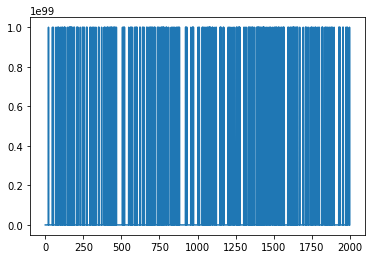

In [13]:
x=range(len(Custo))
plt.plot(x,Custo)